# リポジトリクローン

In [77]:
%cd /content
!rm -rf D-FINE
!git clone https://github.com/Peterande/D-FINE
%cd D-FINE

/content
Cloning into 'D-FINE'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 456 (delta 110), reused 91 (delta 69), pack-reused 291 (from 1)
Receiving objects: 100% (456/456), 214.90 KiB | 1.13 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/D-FINE


# パッケージインストール

In [78]:
!pip install -q calflops onnx onnxruntime onnxsim

# データセット準備（VOC→COCO形式）

In [79]:
%cd /content
!git clone https://github.com/Kazuhito00/YOLOX-Colaboratory-Training-Sample.git
!git clone https://github.com/Kazuhito00/convert_voc_to_coco.git
%cd D-FINE

/content
fatal: destination path 'YOLOX-Colaboratory-Training-Sample' already exists and is not an empty directory.
fatal: destination path 'convert_voc_to_coco' already exists and is not an empty directory.
/content/D-FINE


In [80]:
dataset_directory = '/content/YOLOX-Colaboratory-Training-Sample/02.annotation_data'

In [81]:
import os

# 学習/検証データパス(train/validation data path)
train_directory = './train'
validation_directory = './validation'

# 学習データ格納ディレクトリ作成(Create training data storage directory)
os.makedirs(train_directory, exist_ok=True)
# 検証データ格納ディレクトリ作成(Create verification data storage directory)
os.makedirs(validation_directory, exist_ok=True)

In [82]:
import glob
import shutil
import random

# 学習データの割合(Percentage of training data)
train_ratio = 0.8

# コピー元ファイルリスト取得(Get copy source file list)
annotation_list = sorted(glob.glob(dataset_directory + '/*.xml'))
image_list = sorted(glob.glob(dataset_directory + '/*.jpg'))

file_num = len(annotation_list)

# インデックスシャッフル(shuffle)
index_list = list(range(file_num - 1))
random.shuffle(index_list)

for count, index in enumerate(index_list):
    if count < int(file_num * train_ratio):
        # 学習用データ(Training Data)
        shutil.copy2(annotation_list[index], train_directory)
        shutil.copy2(image_list[index], train_directory)
    else:
        # 検証用データ(Validation Data)
        shutil.copy2(annotation_list[index], validation_directory)
        shutil.copy2(image_list[index], validation_directory)

In [83]:
# Pascal VOC形式 を MS COCO形式へ変換
!python ../convert_voc_to_coco/convert_voc_to_coco.py \
    train train/train_annotations.json \
    --start_image_id=0
!python ../convert_voc_to_coco/convert_voc_to_coco.py \
    validation validation/validation_annotations.json \
    --start_image_id=10000000

Number of xml files: 40
Convert XML to JSON: 100% 40/40 [00:00<00:00, 6949.97it/s]
{'Fish': 218}
Success: train/train_annotations.json
Number of xml files: 9
Convert XML to JSON: 100% 9/9 [00:00<00:00, 6638.89it/s]
{'Fish': 51}
Success: validation/validation_annotations.json


# 学習設定yml準備

In [84]:
%%writefile my_coco_detection.yml

# configs/dataset/coco_detection.yml を参考

task: detection

evaluator:
  type: CocoEvaluator
  iou_types: ['bbox', ]

num_classes: 2                                # 変更(実際のクラス数+1を設定)
remap_mscoco_category: False                  # 変更

train_dataloader:
  type: DataLoader
  dataset:
    type: CocoDetection
    img_folder: ./train/                      # 変更
    ann_file: ./train/train_annotations.json  # 変更
    return_masks: False
    transforms:
      type: Compose
      ops: ~
  shuffle: True
  num_workers: 4
  drop_last: True
  collate_fn:
    type: BatchImageCollateFuncion


val_dataloader:
  type: DataLoader
  dataset:
    type: CocoDetection
    img_folder: ./validation/                           # 変更
    ann_file: ./validation/validation_annotations.json  # 変更
    return_masks: False
    transforms:
      type: Compose
      ops: ~
  shuffle: False
  num_workers: 4
  drop_last: False
  collate_fn:
    type: BatchImageCollateFuncion

Writing my_coco_detection.yml


In [85]:
%%writefile my_runtime.yml

# configs/runtime.yml を参考（今回のサンプルでは変更なし）

print_freq: 100
output_dir: './logs'
checkpoint_freq: 12


sync_bn: True
find_unused_parameters: False


use_amp: False
scaler:
  type: GradScaler
  enabled: True


use_ema: False
ema:
  type: ModelEMA
  decay: 0.9999
  warmups: 1000

Writing my_runtime.yml


In [86]:
%%writefile my_dataloader.yml

# configs/dfine/include/dataloader.yml を参考（今回のサンプルでは変更なし）


train_dataloader:
  dataset:
    transforms:
      ops:
        - {type: RandomPhotometricDistort, p: 0.5}
        - {type: RandomZoomOut, fill: 0}
        - {type: RandomIoUCrop, p: 0.8}
        - {type: SanitizeBoundingBoxes, min_size: 1}
        - {type: RandomHorizontalFlip}
        - {type: Resize, size: [640, 640], }
        - {type: SanitizeBoundingBoxes, min_size: 1}
        - {type: ConvertPILImage, dtype: 'float32', scale: True}
        - {type: ConvertBoxes, fmt: 'cxcywh', normalize: True}
      policy:
        name: stop_epoch
        epoch: 72 # epoch in [71, ~) stop `ops`
        ops: ['RandomPhotometricDistort', 'RandomZoomOut', 'RandomIoUCrop']

  collate_fn:
    type: BatchImageCollateFuncion
    base_size: 640
    base_size_repeat: 3
    stop_epoch: 72 # epoch in [72, ~) stop `multiscales`

  shuffle: True
  total_batch_size: 16  # 変更
  num_workers: 4


val_dataloader:
  dataset:
    transforms:
      ops:
        - {type: Resize, size: [640, 640]}
        - {type: ConvertPILImage, dtype: 'float32', scale: True}
  shuffle: False
  total_batch_size: 16  # 変更
  num_workers: 4

Writing my_dataloader.yml


In [87]:
%%writefile my_optimizer.yml

# configs/dfine/include/optimizer.yml を参考（今回のサンプルでは変更なし）

use_amp: True
use_ema: True
ema:
  type: ModelEMA
  decay: 0.9999
  warmups: 1000
  start: 0


epoches: 72
clip_max_norm: 0.1


optimizer:
  type: AdamW
  params:
    -
      params: '^(?=.*backbone)(?!.*norm).*$'
      lr: 0.0000125
    -
      params: '^(?=.*(?:encoder|decoder))(?=.*(?:norm|bn)).*$'
      weight_decay: 0.

  lr: 0.00025
  betas: [0.9, 0.999]
  weight_decay: 0.000125


lr_scheduler:
  type: MultiStepLR
  milestones: [500]
  gamma: 0.1

lr_warmup_scheduler:
  type: LinearWarmup
  warmup_duration: 500

Writing my_optimizer.yml


In [88]:
%%writefile my_dfine_hgnetv2.yml

# configs/dfine/include/dfine_hgnetv2.yml を参考（今回のサンプルでは変更なし）

task: detection

model: DFINE
criterion: DFINECriterion
postprocessor: DFINEPostProcessor

use_focal_loss: True
eval_spatial_size: [640, 640] # h w

DFINE:
  backbone: HGNetv2
  encoder: HybridEncoder
  decoder: DFINETransformer

HGNetv2:
  pretrained: True
  local_model_dir: weight/hgnetv2/

HybridEncoder:
  in_channels: [512, 1024, 2048]
  feat_strides: [8, 16, 32]

  # intra
  hidden_dim: 256
  use_encoder_idx: [2]
  num_encoder_layers: 1
  nhead: 8
  dim_feedforward: 1024
  dropout: 0.
  enc_act: 'gelu'

  # cross
  expansion: 1.0
  depth_mult: 1
  act: 'silu'


DFINETransformer:
  feat_channels: [256, 256, 256]
  feat_strides: [8, 16, 32]
  hidden_dim: 256
  num_levels: 3

  num_layers: 6
  eval_idx: -1
  num_queries: 300

  num_denoising: 100
  label_noise_ratio: 0.5
  box_noise_scale: 1.0

  # NEW
  reg_max: 32
  reg_scale: 4

  # Auxiliary decoder layers dimension scaling
  # "eg. If num_layers: 6 eval_idx: -4,
  # then layer 3, 4, 5 are auxiliary decoder layers."
  layer_scale: 1  # 2


  num_points: [3, 6, 3] # [4, 4, 4] [3, 6, 3]
  cross_attn_method: default # default, discrete
  query_select_method: default # default, agnostic


DFINEPostProcessor:
  num_top_queries: 300


DFINECriterion:
  weight_dict: {loss_vfl: 1, loss_bbox: 5, loss_giou: 2, loss_fgl: 0.15, loss_ddf: 1.5}
  losses: ['vfl', 'boxes', 'local']
  alpha: 0.75
  gamma: 2.0
  reg_max: 32

  matcher:
    type: HungarianMatcher
    weight_dict: {cost_class: 2, cost_bbox: 5, cost_giou: 2}
    alpha: 0.25
    gamma: 2.0

Writing my_dfine_hgnetv2.yml


In [89]:
%%writefile my_dfine_hgnetv2_s.yml

# configs/dfine/dfine_hgnetv2_s_coco.yml を参考

__include__: [
  './my_coco_detection.yml',            # 変更
  './my_runtime.yml',                   # 変更
  './my_dataloader.yml',                # 変更
  './my_optimizer.yml',                 # 変更
  './my_dfine_hgnetv2.yml',             # 変更
]


output_dir: ./output/dfine_hgnetv2_s    # 変更


DFINE:
  backbone: HGNetv2

HGNetv2:
  name: 'B0'
  return_idx: [1, 2, 3]
  freeze_at: -1
  freeze_norm: False
  use_lab: True

DFINETransformer:
  num_layers: 3  # 4 5 6
  eval_idx: -1  # -2 -3 -4

HybridEncoder:
  in_channels: [256, 512, 1024]
  hidden_dim: 256
  depth_mult: 0.34
  expansion: 0.5

optimizer:
  type: AdamW
  params:
    -
      params: '^(?=.*backbone)(?!.*norm|bn).*$'
      lr: 0.0001
    -
      params: '^(?=.*backbone)(?=.*norm|bn).*$'
      lr: 0.0001
      weight_decay: 0.
    -
      params: '^(?=.*(?:encoder|decoder))(?=.*(?:norm|bn|bias)).*$'
      weight_decay: 0.

  lr: 0.0002
  betas: [0.9, 0.999]
  weight_decay: 0.0001


# Increase to search for the optimal ema
epoches: 132 # 120 + 4n
train_dataloader:
  dataset:
    transforms:
      policy:
        epoch: 120
  collate_fn:
    stop_epoch: 120
    ema_restart_decay: 0.9999
    base_size_repeat: 20

Writing my_dfine_hgnetv2_s.yml


# 学習実施

In [90]:
!CUDA_VISIBLE_DEVICES=0 torchrun --nproc_per_node=1 train.py -c my_dfine_hgnetv2_s.yml --use-amp --seed=0 2>&1 | tee train_log.txt

2024-10-28 02:29:56.746842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 02:29:56.768047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 02:29:56.774021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 02:29:56.788791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 02:29:57.860813: W tensorflow/comp

# ONNX出力

In [91]:
!python tools/deployment/export_onnx.py \
    --check \
    -c my_dfine_hgnetv2_s.yml \
    -r output/dfine_hgnetv2_s/best.pth

2024-10-28 02:44:09.631708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 02:44:09.706855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 02:44:09.727597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 02:44:09.791164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 02:44:13.832176: W tensorflow/comp

In [92]:
!cp output/dfine_hgnetv2_s/best.onnx dfine_hgnetv2_s.onnx

# 推論テスト

In [93]:
import onnxruntime

# モデル読み込み
onnx_session = onnxruntime.InferenceSession(
    'dfine_hgnetv2_s.onnx',
    providers=[
        'CPUExecutionProvider',
    ],
)
input_size = onnx_session.get_inputs()[0].shape
input_width, input_height = input_size[3], input_size[2]

print(onnx_session.get_providers())
print('input size:',input_size)

['CPUExecutionProvider']
input size: ['N', 3, 640, 640]


In [94]:
import cv2
import numpy as np

# 画像読み込み
image = cv2.imread('/content/YOLOX-Colaboratory-Training-Sample/02.annotation_data/000001.jpg')
image_height, image_width, _ = image.shape
original_size = np.array([[image_width, image_height]], dtype=np.int64)

# 前処理：BGR->RGB、リサイズ、正規化、NCHW
input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (input_width, input_height))
input_image = input_image.astype(np.float32) / 255.0
input_image = np.transpose(input_image, (2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)

In [95]:
%%time

# 推論
output = onnx_session.run(
    None,
    input_feed={'images': input_image, "orig_target_sizes": original_size}
)

labels, bboxes, scores = output

CPU times: user 458 ms, sys: 35 ms, total: 493 ms
Wall time: 495 ms


# 結果確認

In [103]:
import copy

# 描画
debug_image = copy.deepcopy(image)
score_threshold = 0.4

for label, bbox, score in zip(labels[0], bboxes[0], scores[0]):
    if score < score_threshold:
        continue

    cv2.rectangle(
        debug_image,
        (int(bbox[0]), int(bbox[1])),
        (int(bbox[2]), int(bbox[3])),
        (0, 255, 0),
        2,
    )
    cv2.putText(
        debug_image,
        str(label),
        (int(bbox[0]), int(bbox[1]-8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2,
    )

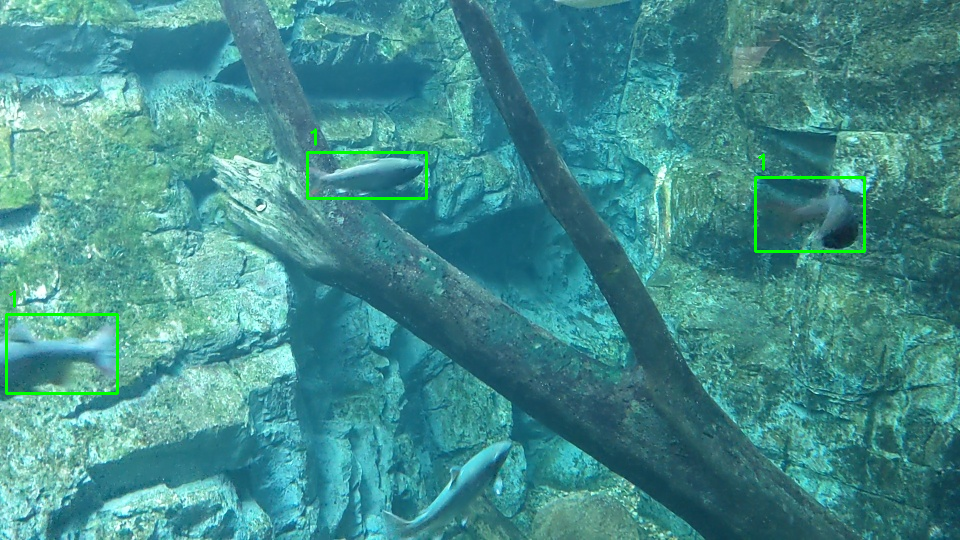

In [104]:
from google.colab.patches import cv2_imshow

cv2_imshow(debug_image)